In [1]:
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

import dataset_utils.utils as utils
import dataset_utils.visualize as visualize

In [2]:
paths = {}
with open("dataset_utils/paths.json", 'r') as f:
    paths = json.load(f)

train_set = utils.Dataset(paths, 1)
ntrain_set = len(train_set.images)

test_set = utils.Dataset(paths, 0)
ntest_set = len(test_set.images)

In [3]:
nannotations = []
activities = dict.fromkeys(train_set.activiti_names, 0)
categories = dict.fromkeys(train_set.categori_names, 0)
cat_activities = {}

jnt_names = list(train_set.images[0].idx_to_jnt.values())
jnt_ids = list(train_set.images[0].idx_to_jnt.keys())
joints = dict.fromkeys(jnt_ids, 0)
joints_visibility = [0,0]

for im in train_set.images:
    nannotations.append(len(im.annorect))
    
    act = im.act_name
    cat = im.cat_name
    
    
    if(act):
        activities[act] += 1

    if(cat):
        categories[cat] += 1
          
    if(cat and act):
        if cat in cat_activities:
            if act in cat_activities[cat]:
                cat_activities[cat][act] += 1
            else:
                cat_activities[cat][act] = 1
        else:
            cat_activities[cat] = {act : 1}
    
    for points in im.points:
        for point in points:
            joints[point["id"]] += 1
            if("is_visible" in point):
                if point["is_visible"] == True:
                    joints_visibility[0] += 1
                elif point["is_visible"] == False:
                    joints_visibility[1] += 1
                
avg_annotations = np.round(np.sum(nannotations)/ntrain_set,2)

In [4]:
print('Images in training set: {}'.format(ntrain_set))
print('Images in test set: {} (no annotations)'.format(ntest_set))
print()
print('Annotations in training set: {}'.format(np.sum(nannotations)))
print('Annotations average in training set: {}'.format(avg_annotations))
print()
print('Categories: {}'.format(len(train_set.categori_names)))
print('Activities: {}'.format(len(train_set.activiti_names)))
print()
print('Visible joints: {} ({:.2f}%)'.format(joints_visibility[0], joints_visibility[0]/np.sum(joints_visibility) * 100))
print('Nonvisible joints: {} ({:.2f}%)'.format(joints_visibility[1], joints_visibility[1]/np.sum(joints_visibility) * 100))
print()

df = pd.DataFrame({
    'class_name': list(categories.keys()),
    'annotations': list(categories.values())
})
print(df)

Images in training set: 17281
Images in test set: 6619 (no annotations)

Annotations in training set: 28563
Annotations average in training set: 1.65

Categories: 20
Activities: 396

Visible joints: 252894 (73.61%)
Nonvisible joints: 90672 (26.39%)

                class_name  annotations
0                   sports         3431
1   inactivity quiet/light          184
2            miscellaneous          737
3               occupation         2296
4         water activities         1003
5          home activities         1373
6          lawn and garden         1090
7     religious activities          116
8        winter activities          739
9    conditioning exercise         1677
10               bicycling          515
11     fishing and hunting          703
12                 dancing          696
13                 walking          576
14                 running          290
15               self care           89
16             home repair         1065
17           music playing    

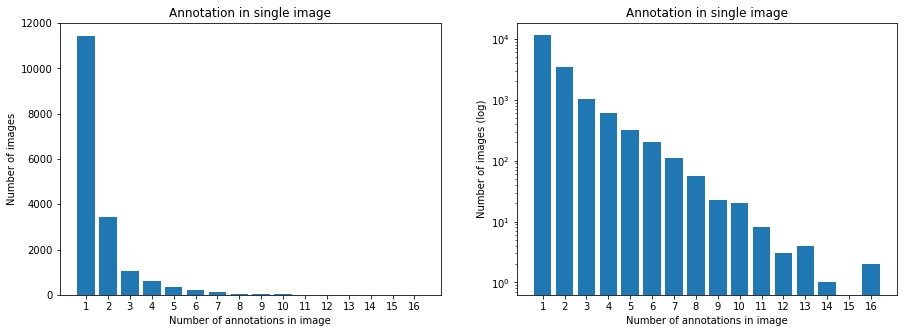

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axs[0]
n, bins = np.histogram(nannotations, np.max(nannotations)-1)
p2 = ax.bar(bins[:-1], n)
tx = ax.set_xticks(bins[:-1])
ax.set_title('Annotation in single image')
ax.set_xlabel('Number of annotations in image')
ax.set_ylabel('Number of images')


ax = axs[1]
p1 = ax.bar(bins[:-1], n)
tx = ax.set_xticks(bins[:-1])
ax.set_yscale('log')
ax.set_title('Annotation in single image')
ax.set_xlabel('Number of annotations in image')
yl = ax.set_ylabel('Number of images (log)')


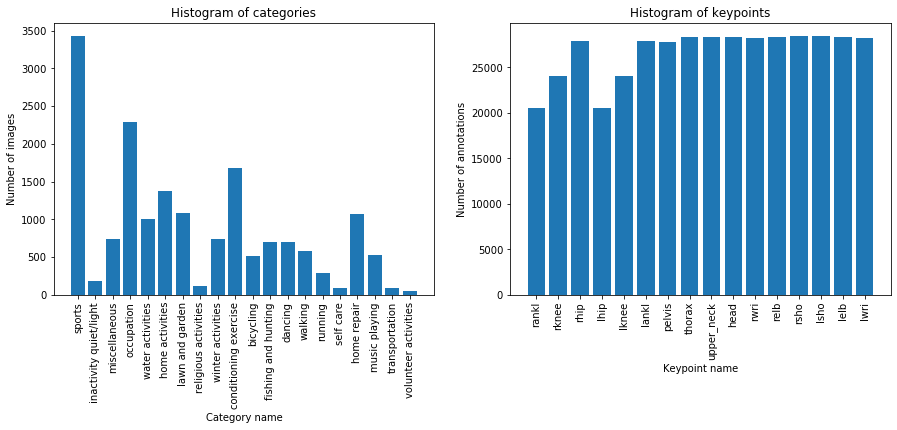

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axs[0]

ax.bar(categories.keys(), categories.values())
plt.sca(ax)
xt = plt.xticks(rotation='vertical')
ax.set_title('Histogram of categories')
ax.set_xlabel('Category name')
ax.set_ylabel('Number of images')

names = []
for k in jnt_ids:
    names.append(jnt_names[k])
ax = axs[1]
ax.bar(names, joints.values())
plt.sca(ax)
xt = plt.xticks(rotation='vertical')
ax.set_title('Histogram of keypoints')
ax.set_xlabel('Keypoint name')
yl = ax.set_ylabel('Number of annotations')


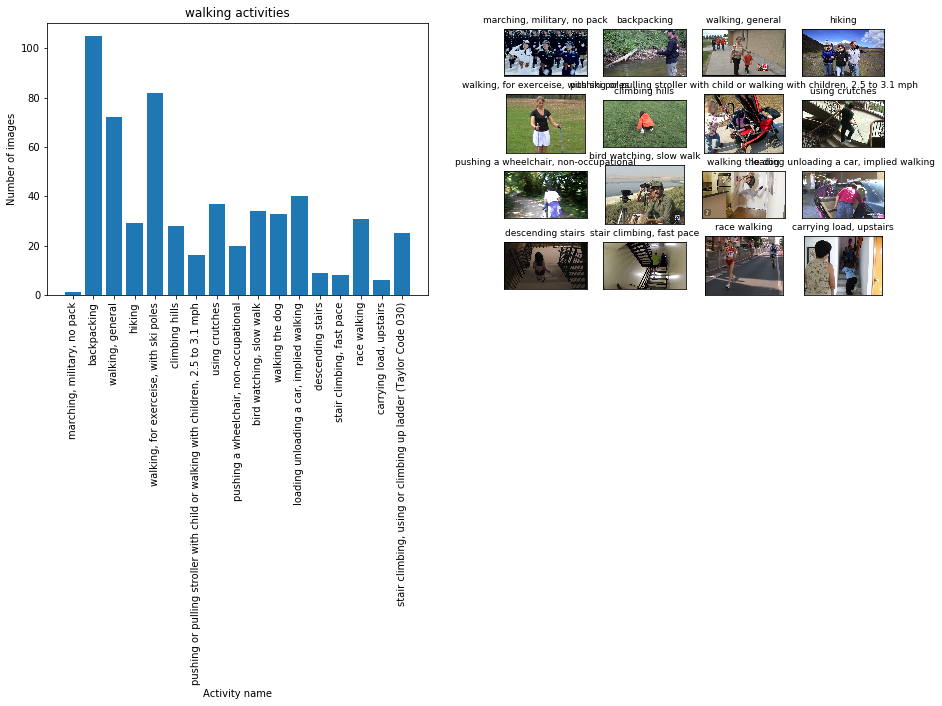

In [7]:
cat = "walking"

names = list(cat_activities[cat].keys())
num = list(cat_activities[cat].values())
imgs_n = int(np.floor(np.sqrt(len(names))))
images = []
for n in names:
    im = train_set.get_random_images_from(n, 1)
    images.append(im)


fig = plt.figure( figsize=(15, 5))
gs0 = fig.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(1, 1)
gs01 = gs0[1].subgridspec(imgs_n, imgs_n)

ax0 = fig.add_subplot(gs00[0])
ax0.bar(names, num)
plt.sca(ax0)
xt = plt.xticks(rotation='vertical')
ax0.set_title(cat + ' activities')
ax0.set_xlabel('Activity name')
ax0.set_ylabel('Number of images')

k = 0
for a in range(imgs_n):
    for b in range(imgs_n):
        axn = fig.add_subplot(gs01[a, b])
        axn.set(xticks=[], yticks=[])
        im = visualize.load_image(images[k])
        axn.imshow(im[0])
        axn.set_title(names[k], fontsize=9)
        k += 1

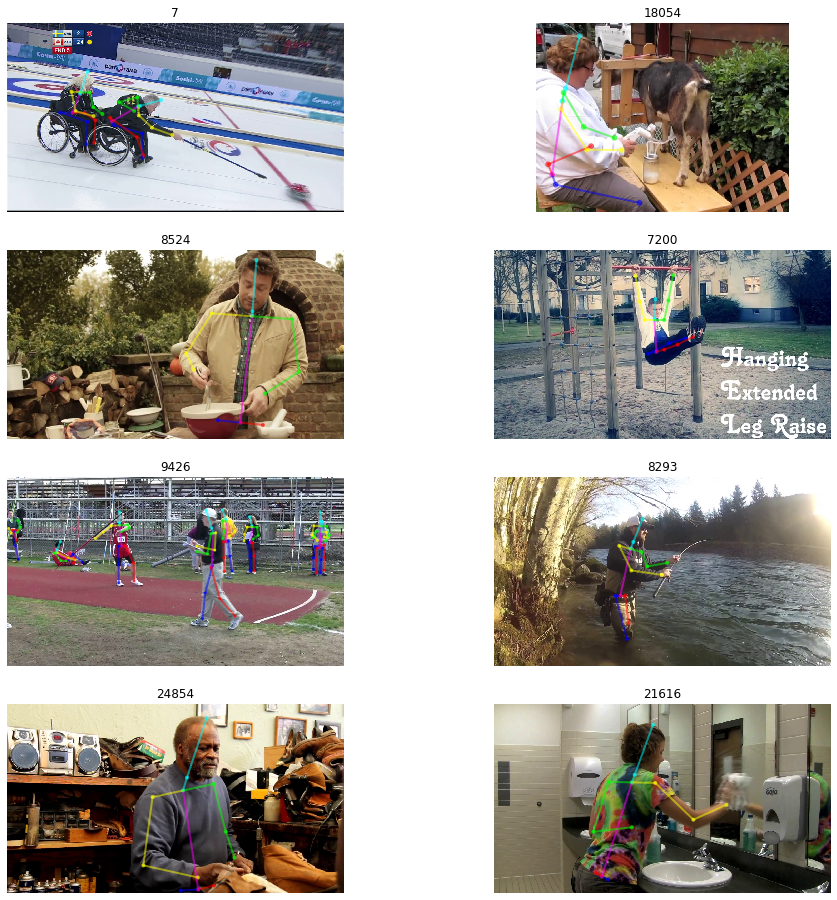

In [8]:
images = train_set.get_random_images(8)
images[0] = train_set.get_image_by_id(7)
visualize.visualize_image_annotations(images, connectins_w=2, joints_r=6, figsize=(16,16))

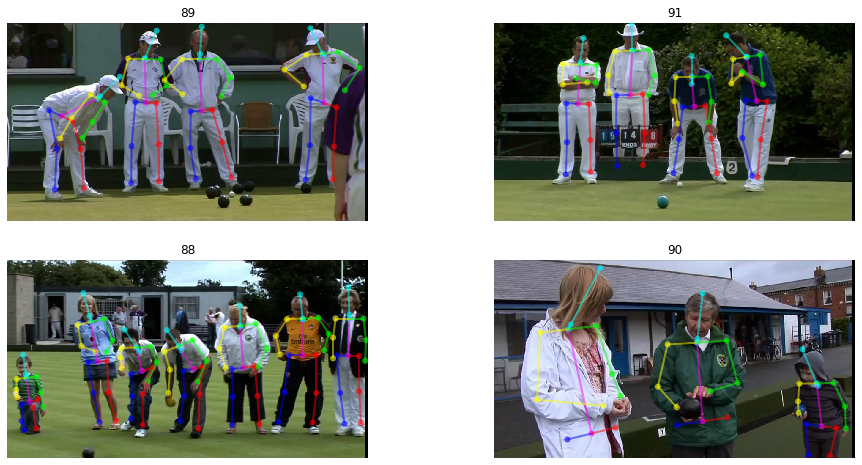

In [9]:
imgs = train_set.get_random_images_from('lawn bowling, bocce ball, outdoor', 4)
visualize.visualize_image_annotations(imgs, connectins_w=2, joints_r=6, figsize=(16,8))

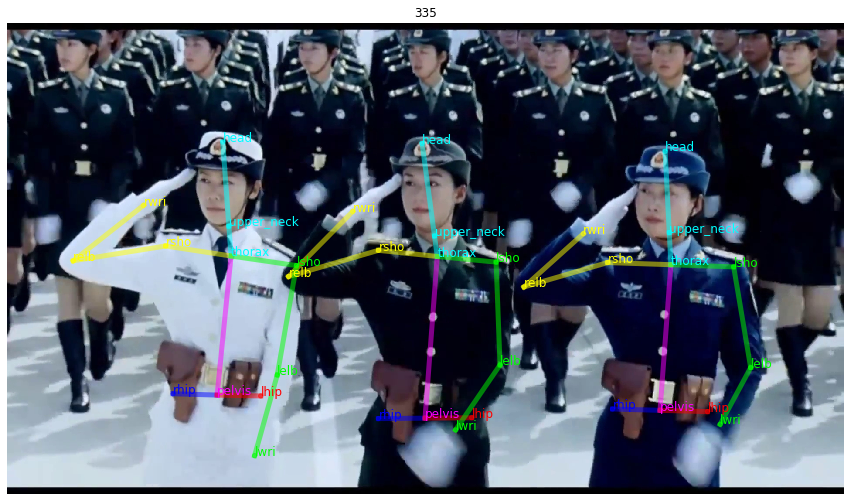

In [10]:
visualize.visualize_image_annotations(train_set.get_image_by_id(335), joints_name=True)

In [11]:
new_train_set_imgidx = []
new_validation_set_imgidx = []
train_set_percent = 0.7


for act in train_set.activiti_names:
    ind = train_set.get_percent_imgidx_from(act, train_set_percent, random=False)
    new_train_set_imgidx = new_train_set_imgidx + ind
    
for idx in train_set.imgidx_to_idx:
    if idx not in new_train_set_imgidx:
        new_validation_set_imgidx.append(idx)

In [12]:
nntrain_set = len(new_train_set_imgidx)
nnvalid_set = len(new_validation_set_imgidx)
print('New train set {} - {:.2f}%'.format(nntrain_set, nntrain_set/ntrain_set) )
print('New validation set {} - {:.2f}%'.format(nnvalid_set, nnvalid_set/ntrain_set) )

New train set 11900 - 0.69%
New validation set 5381 - 0.31%


In [13]:
#save ids
'''
with open('new_train_set_imgidx.json', 'w') as file:
    json.dump(new_train_set_imgidx, file)
    
with open('new_validation_set_imgidx.json', 'w') as file:
    json.dump(new_validation_set_imgidx, file)
'''

"\nwith open('new_train_set_imgidx.json', 'w') as file:\n    json.dump(new_train_set_imgidx, file)\n    \nwith open('new_validation_set_imgidx.json', 'w') as file:\n    json.dump(new_validation_set_imgidx, file)\n"